Importing the required dependancies: 

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
CLIENT_ID = 'KTLBN10PJAGAA2KUHO22M2MY0NZGEDKWPXJOIBBHDAZWGIXS' # your Foursquare ID
CLIENT_SECRET = '1WVQXWVNKQA0OGMLWGSA40NRD1G2U2TL1IGEULT1MIGEK5EQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KTLBN10PJAGAA2KUHO22M2MY0NZGEDKWPXJOIBBHDAZWGIXS
CLIENT_SECRET:1WVQXWVNKQA0OGMLWGSA40NRD1G2U2TL1IGEULT1MIGEK5EQ


In [4]:
def get_venues(lat,lng): 
    #set variables
    radius=1000
    LIMIT=100
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data


In [6]:
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

In [9]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_resturants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(japanese_resturants)))
    for resturant_detail in japanese_resturants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Japanese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Japanese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Japanese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Japanese Resturants in Riverdale, Bronx:2
( 6 / 306 ) Japanese Resturants in Kingsbridge, Bronx:2
( 7 / 306 ) Japanese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Japanese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Japanese Resturants in Norwood, Bronx:0
( 10 / 306 ) Japanese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Japanese Resturants in Baychester, Bronx:0
( 12 / 306 ) Japanese Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Japanese Resturants in City Island, Bronx:1
( 14 / 306 ) Japanese Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Japanese Resturants in University Heights, Bronx:0
( 16 / 306 ) Japanese Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Japanese Resturants in Fordham, Bronx:0
( 18 / 306 ) Japanese Resturants in Ea

In [10]:
japanese_rest_ny.shape

(190, 4)

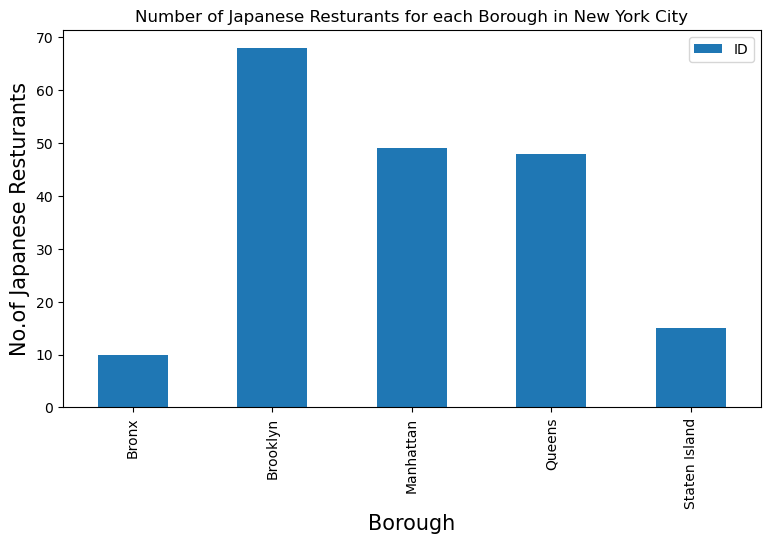

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Resturants', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

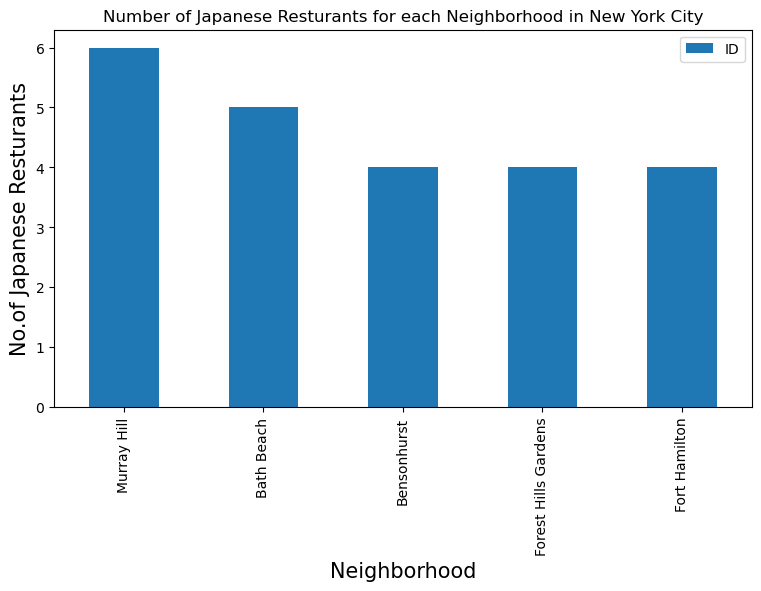

In [12]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Resturants', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [13]:
def get_venue_details(venue_id):
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [14]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                      Name  Likes  Rating  Tips
0  503cfaffe4b066d39de5005a  Aoyu Japanese Restaurant     32     9.0    19
( 1 / 190 ) processed
                         ID             Name  Likes  Rating  Tips
0  4b0b311af964a520642e23e3  Palace of Japan     38     8.5    26
( 2 / 190 ) processed
                         ID                      Name  Likes  Rating  Tips
0  503cfaffe4b066d39de5005a  Aoyu Japanese Restaurant     32     9.0    19
( 3 / 190 ) processed
                         ID             Name  Likes  Rating  Tips
0  4b0b311af964a520642e23e3  Palace of Japan     38     8.5    26
( 4 / 190 ) processed
                         ID                                         Name  \
0  4dbdf3d790a02849cbd675be  Ohana Japanese Habachi Seafood & Steakhouse   

   Likes  Rating  Tips  
0     34     7.7    18  
( 5 / 190 ) processed
                         ID      Name  Likes  Rating  Tips
0  5d40d7a398a00a0008b4c8ca  Benihana      0     7.6     0
( 6 /

In [15]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny.csv', index=False)

In [16]:
japanese_rest_stats_ny_csv=pd.read_csv('japanese_rest_stats_ny.csv')

In [17]:
japanese_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.0,19
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan,38,8.5,26
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.0,19
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan,38,8.5,26
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse,34,7.7,18


In [18]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       190 non-null    object 
 1   Neighborhood  190 non-null    object 
 2   ID            190 non-null    object 
 3   Name          190 non-null    object 
 4   Likes         190 non-null    object 
 5   Rating        190 non-null    float64
 6   Tips          190 non-null    object 
dtypes: float64(1), object(6)
memory usage: 10.5+ KB


In [19]:
japanese_rest_stats_ny['Likes']=japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips']=japanese_rest_stats_ny['Tips'].astype('float64')

In [20]:
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Flatiron
ID              4f7b61f6e4b07aaa5d524842
Name                 OOTOYA 大戸屋 (OOTOYA)
Likes                               1221
Rating                                 9
Tips                                 274
Name: 179, dtype: object

In [21]:
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood           East Williamsburg
ID              52517e05498ec2e28c792fa2
Name               Brooklyn Ball Factory
Likes                                298
Rating                               9.2
Tips                                  89
Name: 57, dtype: object

In [22]:
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              454f7cc4f964a520dc3c1fe3
Name                            Morimoto
Likes                                792
Rating                               8.7
Tips                                 353
Name: 84, dtype: object

In [23]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [24]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
67,Lower East Side,9.200000
31,East Village,9.200000
98,Stuyvesant Town,9.200000
80,Noho,9.150000
22,Cobble Hill,9.100000
108,West Village,9.050000
50,Greenwich Village,9.050000
56,Hunters Point,9.033333
87,Ravenswood,9.000000
35,Flatiron,9.000000


In [25]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [26]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.671429
0,Bronx,7.570000
1,Brooklyn,7.519118
3,Queens,7.210417
4,Staten Island,6.700000


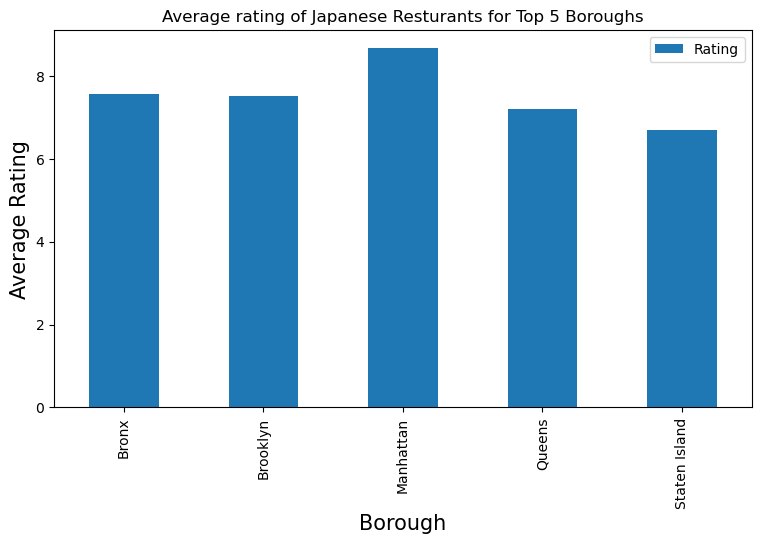

In [28]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Japanese Resturants for Top 5 Boroughs')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()